# Objective

The goal of this notebook is to build a machine learning model that allows us **to predict weekly bookings for each hotel** over time.

# Prep notebook

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn.model_selection
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from booking_forecaster.configs import params

RND = 42

# Load data

In [2]:
df_l2 = pd.read_parquet(params.DATA_PATH / "hotel_bookings_l2.parquet")

In [3]:
df_l2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149899 entries, 0 to 149898
Data columns (total 48 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   hotel_name                 149899 non-null  category      
 1   season                     149899 non-null  category      
 2   arrival_date               149899 non-null  datetime64[ns]
 3   departure_date             149899 non-null  datetime64[ns]
 4   guest_type                 149899 non-null  category      
 5   customer_type              149899 non-null  category      
 6   company                    149899 non-null  int64         
 7   adr                        149899 non-null  float64       
 8   num_guests                 149899 non-null  int64         
 9   adults                     149899 non-null  int64         
 10  children                   149899 non-null  int64         
 11  babies                     149899 non-null  int64   

In [4]:
df_l2['company'] = df_l2['company'].astype('category')

# Data prep

Here we would aggregate the total number of bookings at year-week level for all 5 hotels. 

Also here we take all the bookings i.e. both cancelled and not-cancelled ones since we assume that we are interested to predict how many all bookings could be made in the upcoming week and it doesn't matter if they are cancelled later.

Also, p.s., we only have a cancellation status and not _when_ the cancellation was done we would 

In [5]:
df_l3 = df_l2.groupby(['hotel_name', 'booking_date_year_week'], as_index=False).size().rename(columns={'size': 'n_bookings'})

/tmp/ipykernel_27873/891458482.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_l3 = df_l2.groupby(['hotel_name', 'booking_date_year_week'], as_index=False).size().rename(columns={'size': 'n_bookings'})


In [6]:
df_l3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   hotel_name              1065 non-null   category
 1   booking_date_year_week  1065 non-null   int64   
 2   n_bookings              1065 non-null   int64   
dtypes: category(1), int64(2)
memory usage: 18.0 KB


In [7]:
df_l3.head()

,hotel_name,booking_date_year_week,n_bookings
0,Algarve Retreat,201401,10
1,Algarve Retreat,201416,0
2,Algarve Retreat,201418,2
3,Algarve Retreat,201424,0
4,Algarve Retreat,201427,0


In [8]:
week_range = range(1, 53) # since none of the years were leap year
year_range = range(2014, 2019)
all_year_week_df = pd.DataFrame({"booking_date_year_week": list(map(lambda x: int(f"{x[0]}{x[1]:02}"), itertools.product(year_range, week_range)))})

In [9]:
all_year_week_df = all_year_week_df.loc[
    (all_year_week_df['booking_date_year_week'] >= df_l3['booking_date_year_week'].min()) &\
    (all_year_week_df['booking_date_year_week'] <= df_l3['booking_date_year_week'].max())
]

In [10]:
all_year_week_hotel_df = all_year_week_df.merge(df_l3['hotel_name'].drop_duplicates(), how='cross')

In [11]:
df_l3 = all_year_week_hotel_df.merge(df_l3, on=['booking_date_year_week', 'hotel_name'], how='left')

In [12]:
df_l3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1165 entries, 0 to 1164
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   booking_date_year_week  1165 non-null   int64   
 1   hotel_name              1165 non-null   category
 2   n_bookings              1055 non-null   float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 19.7 KB


In [13]:
df_l3.sort_values(['hotel_name', 'booking_date_year_week'])

,booking_date_year_week,hotel_name,n_bookings
0,201401,Algarve Retreat,10.0
5,201402,Algarve Retreat,NaN
10,201403,Algarve Retreat,NaN
15,201404,Algarve Retreat,NaN
20,201405,Algarve Retreat,NaN
...,...,...,...
1144,201821,Porto City Hotel,8.0
1149,201822,Porto City Hotel,10.0
1154,201823,Porto City Hotel,2.0
1159,201824,Porto City Hotel,2.0


In [14]:
df_l3['n_bookings'] = df_l3['n_bookings'].fillna(0.0)

Note - we did not do any kind of filling in the previous notebooks as we did not think it was necessary. 

# Split data

Since we are dealing with time series data we would do the splitting accordingly. Ideally, it needs to be a combination of stratified and forward expanding.

In most forecasting tasks we decide and fix the number of time steps to forecast for. Let's say, its $H$

For this task we assume - $H = 1$

In [15]:
H = 1

In [16]:
def get_splits(df, k=10, max_train_size=50):
    tscv = sklearn.model_selection.TimeSeriesSplit(n_splits=k, test_size=H, max_train_size=max_train_size)
    train_df_list = []
    test_df_list = []
    for hotel, gdf in df.groupby('hotel_name'):
        for i, (train_index, test_index) in enumerate(tscv.split(gdf)):
            df_train_fold = gdf.iloc[train_index].copy()
            df_train_fold['fold'] = i+1

            df_test_fold = gdf.iloc[test_index].copy()
            df_test_fold['fold'] = i+1
            
            train_df_list.append(df_train_fold)
            test_df_list.append(df_test_fold)
    return pd.concat(train_df_list).reset_index(drop=True), pd.concat(test_df_list).reset_index(drop=True)

In [17]:
df_train, df_test = get_splits(df_l3, max_train_size=None)

/tmp/ipykernel_27873/3223953760.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for hotel, gdf in df.groupby('hotel_name'):


In [18]:
df_train.groupby(['hotel_name', 'fold']).agg({"booking_date_year_week": [min, max, len]})

/tmp/ipykernel_27873/4289803997.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby(['hotel_name', 'fold']).agg({"booking_date_year_week": [min, max, len]})
/tmp/ipykernel_27873/4289803997.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'min' instead.
  df_train.groupby(['hotel_name', 'fold']).agg({"booking_date_year_week": [min, max, len]})
/tmp/ipykernel_27873/4289803997.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'max' instead.
  df_train.groupby(['hotel

booking_date_year_week             
                                           min     max  len
hotel_name         fold                                    
Algarve Retreat    1                    201401  201815  223
                   2                    201401  201816  224
                   3                    201401  201817  225
                   4                    201401  201818  226
                   5                    201401  201819  227
                   6                    201401  201820  228
                   7                    201401  201821  229
                   8                    201401  201822  230
                   9                    201401  201823  231
                   10                   201401  201824  232
Braga City Hotel   1                    201401  201815  223
                   2                    201401  201816  224
                   3                    201401  201817  225
                   4                    201401  201818  226
                   5                    201401  201819  227
                   6                    201401  201820  228
                   7                    201401  201821  229
                   8                    201401  201822  230
                   9                    201401  201823  231
                   10                   201401  201824  232
Duro Valley Resort 1                    201401  201815  223
                   2                    201401  201816  224
                   3                    201401  201817  225
                   4                    201401  201818  226
                   5                    201401  201819  227
                   6                    201401  201820  228
                   7                    201401  201821  229
                   8                    201401  201822  230
                   9                    201401  201823  231
                   10                   201401  201824  232
Lisbon City Hotel  1                    201401  201815  223
                   2                    201401  201816  224
                   3                    201401  201817  225
                   4                    201401  201818  226
                   5                    201401  201819  227
                   6                    201401  201820  228
                   7                    201401  201821  229
                   8                    201401  201822  230
                   9                    201401  201823  231
                   10                   201401  201824  232
Porto City Hotel   1                    201401  201815  223
                   2                    201401  201816  224
                   3                    201401  201817  225
                   4                    201401  201818  226
                   5                    201401  201819  227
                   6                    201401  201820  228
                   7                    201401  201821  229
                   8                    201401  201822  230
                   9                    201401  201823  231
                   10                   201401  201824  232

In [19]:
df_test.loc[df_test['hotel_name'] == 'Algarve Retreat']

,booking_date_year_week,hotel_name,n_bookings,fold
0,201816,Algarve Retreat,15.0,1
1,201817,Algarve Retreat,16.0,2
2,201818,Algarve Retreat,13.0,3
3,201819,Algarve Retreat,8.0,4
4,201820,Algarve Retreat,11.0,5
5,201821,Algarve Retreat,5.0,6
6,201822,Algarve Retreat,3.0,7
7,201823,Algarve Retreat,2.0,8
8,201824,Algarve Retreat,7.0,9
9,201825,Algarve Retreat,2.0,10


In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11375 entries, 0 to 11374
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   booking_date_year_week  11375 non-null  int64   
 1   hotel_name              11375 non-null  category
 2   n_bookings              11375 non-null  float64 
 3   fold                    11375 non-null  int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 278.0 KB


In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   booking_date_year_week  50 non-null     int64   
 1   hotel_name              50 non-null     category
 2   n_bookings              50 non-null     float64 
 3   fold                    50 non-null     int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 1.6 KB


In a normal setting we usually keep 3 datasets each for training, testing and validating but since we don't want to delve into hyperparameter tuning in order to limit the scope of the task we keep only 2 for now.

# Model training

## Model 1: ARIMA model

In this approach we use a basic ARIMA model with order (1,1,1). 

The main reason to use such a model is because of:
1. Interpretability
2. Be able to use just the time-series as the only feature for training. This usually gets a bit complicated with other kinds of models.
3. Gives us a good baseline.

P.S. we don't intend to tune these hyperparameters because it would require more time and effort and is probably out of the scope of this task. However, if we wish we could use something like `statsforecast.auto_arima` package that automatically does it for us.

In [22]:
pred_df_list = []
for (hotel, fold), gdf in df_train.groupby(['hotel_name', 'fold']):
    df_filtered = gdf.copy()
    df_filtered.set_index('booking_date_year_week', inplace=True)
    df_filtered.sort_index(inplace=True)
    
    time_series = df_filtered['n_bookings']

    # ARIMA only works only if the series is stationary
    time_series_diff = time_series.diff().dropna()
    # still confirm
    if adfuller(time_series_diff)[0] < 0.05:
        # we are training one model for each fold and hotel
        model = ARIMA(time_series_diff, order=(1,1,1))
        model_fit = model.fit()
        # add the diff prediction to the last known value to get the predictions in the actual scale
        fcast = model_fit.get_forecast(steps=1).summary_frame(alpha=0.05)  # 95% conf

        pred = time_series.tail(1).values[0] + fcast['mean'].values[0]
        
        pred_df_list.append({
            'pred_n_bookings': pred,
            'ci_lb': pred + fcast['mean_ci_lower'].values[0],
            'ci_ub': pred + fcast['mean_ci_upper'].values[0],
            'fold': fold,
            'hotel_name': hotel
        })

df_pred_arima = pd.DataFrame(pred_df_list)

/tmp/ipykernel_27873/3718281620.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (hotel, fold), gdf in df_train.groupby(['hotel_name', 'fold']):
/home/kappa/Documents/code/non_git/tui_task/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kappa/Documents/code/non_git/tui_task/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kappa/Documents/code/non_git/tui_task/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be

In [23]:
df_pred_arima.head()

,pred_n_bookings,ci_lb,ci_ub,fold,hotel_name
0,16.833384,-56.095944,87.429480,1,Algarve Retreat
1,16.279609,-54.041739,89.160176,2,Algarve Retreat
2,15.637183,-56.175221,86.723952,3,Algarve Retreat
3,14.271057,-55.739605,86.823832,4,Algarve Retreat
4,10.058976,-59.006866,83.242769,5,Algarve Retreat


In [24]:
df_eval = df_test.merge(df_pred_arima, on=['fold', 'hotel_name'], how='left')

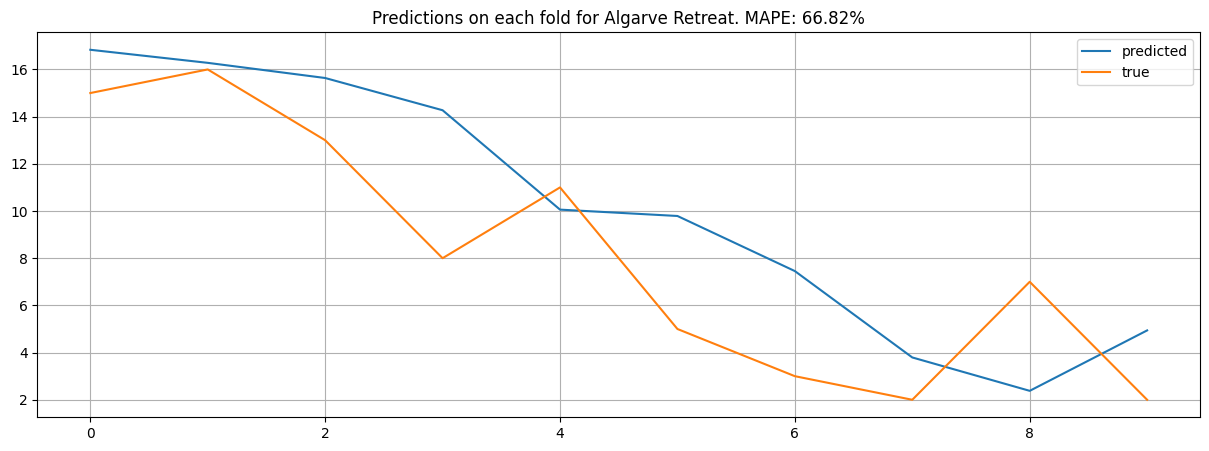

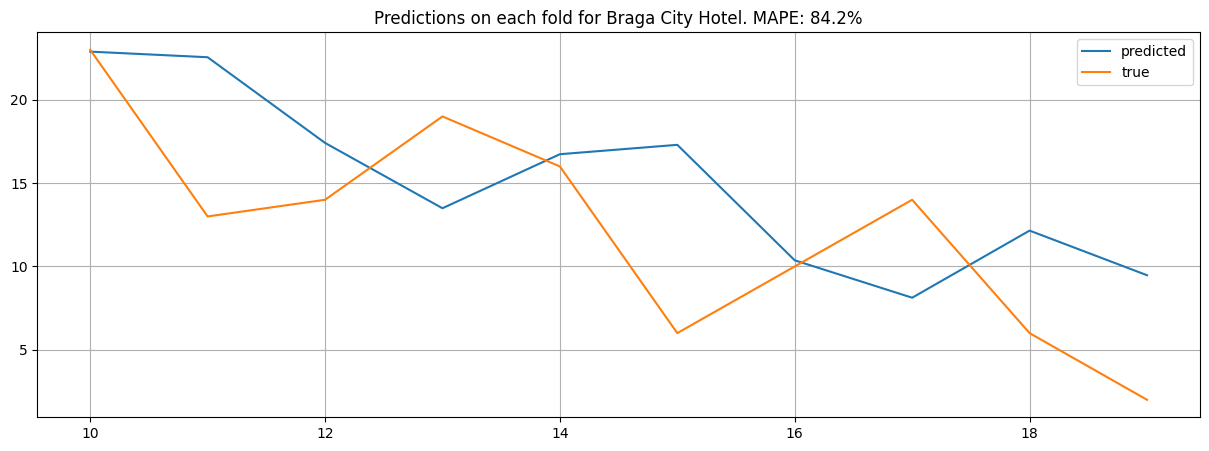

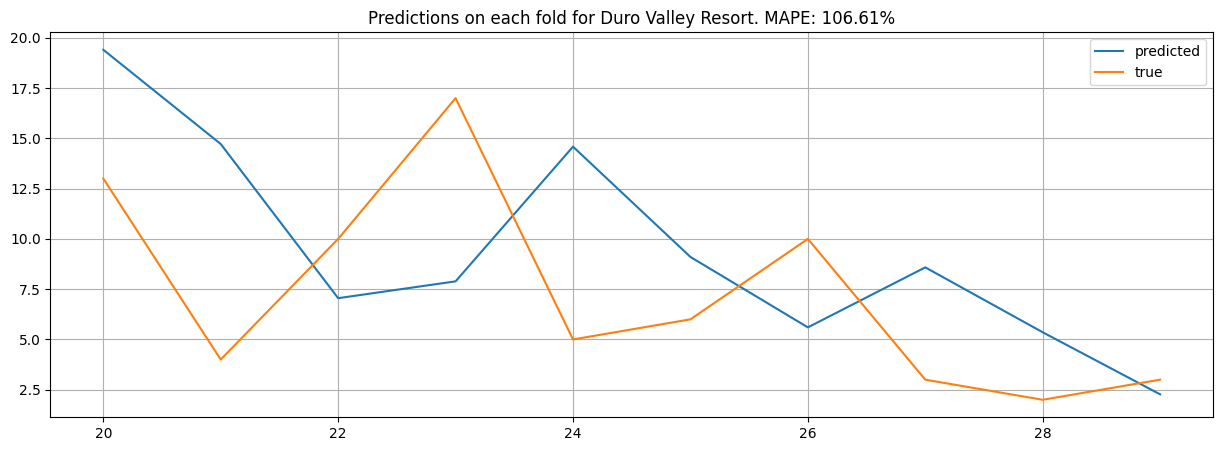

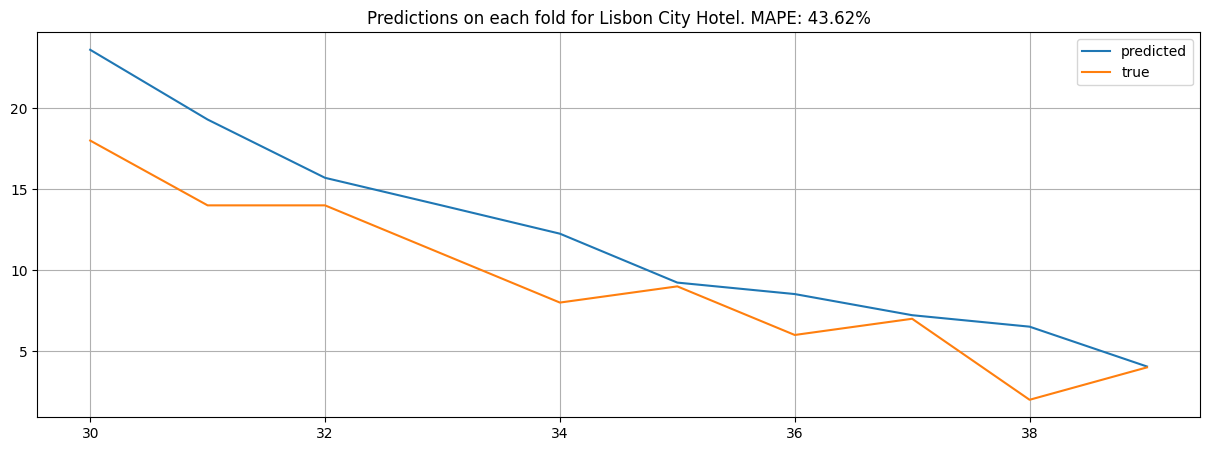

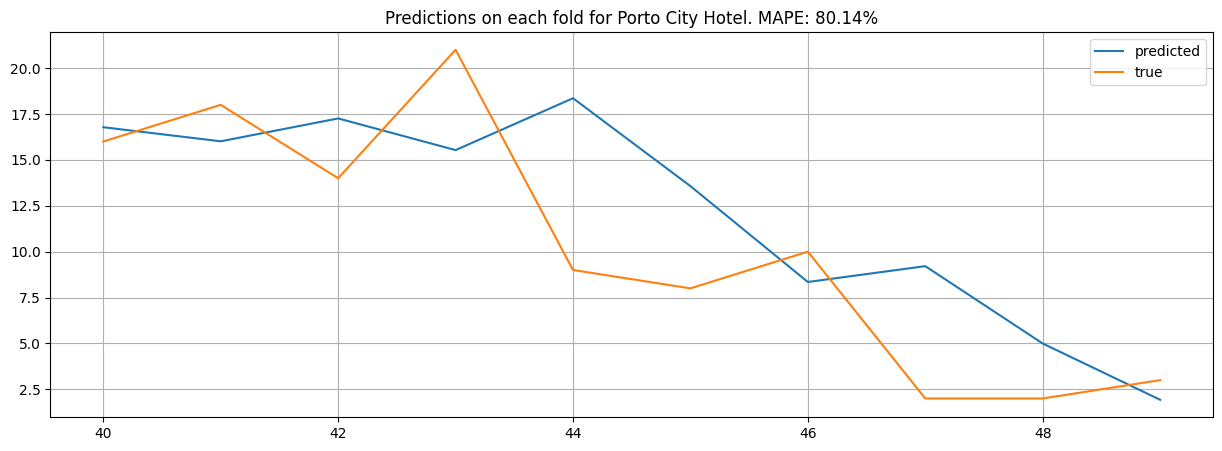

In [25]:
for hotel, gdf in df_eval.groupby('hotel_name'):
    fig = plt.figure(figsize=[15,5])
    plt.plot(gdf['pred_n_bookings'], label='predicted')
    plt.plot(gdf['n_bookings'], label='true')
    plt.title(f"Predictions on each fold for {hotel}. MAPE: {round(sklearn.metrics.mean_absolute_percentage_error(gdf['n_bookings'], gdf['pred_n_bookings'])*100, 2)}%")
    plt.grid(True)
    plt.legend()

Ofcourse there is room for improvement but for a simple untuned model the predicted trends don't look that bad !

In addition to the above we could have also done the following:
1. Tried to transform our series further with something like log, square-root or Box-Cox and then fed it to the ARIMA model.
2. Added more exogenous features like time-series of `adr`, `num_bookings` etc.

Due to time constraints we skip doing those.

## Model 2: Random forest

For this approach we make use of a Random Forest (ensemble) model (with default hyperparameters) - the rationale behind it are:
1. to be free from any assumptions about the nature of the underlying data (such as normality, equivalent scaling etc.).
2. to be free from the obligation to impute and fill for the time periods where there is no data.
3. to be able to generalize for the non-linear (and co-linear) interactions between the predictors and the target (and other predictors).
4. to try out an approach that doesn't rely (or assume) any relations between observations and expect them to be independent (but not identically distributed) - note this comes with its own pros and cons.

### Feature engineering

For this section let's engineer a few features that I think could add some value in exposing some underlying patterns.

In [26]:
target_col = 'n_bookings'

num_cols = [
    'adr',
    'num_guests',
    'adults',
    'children',
    'babies',
     # rolling stats may not make sense in these but still
    'booking_duration',
    'n_days_booked_pre_arrival'
]

cat_columns = list(df_l2.select_dtypes(['category', 'bool']).columns)
# we intentionally remove the below

# because of high cardinality - we will derive relevant stats from it later
cat_columns.remove('source_country') 

# because we plan to engineer features separately for each hotel and concatenate them after.
# however, depending on our training strategy we could either train one model for each hotel, or 
# one for all - in which case this should be included latter as a categorical feature
cat_columns.remove('hotel_name') 

# as observed from the exploration this doesn't add any significant information
cat_columns.remove('company') 

# for the features that need lags
lag_config = {
    target_col: [1,2,3,4,5]
}

# the ones that don't need to go into feature engineering
time_ind_col = 'booking_date_year_week'

extra_num_cols = [
]

extra_cat_cols = [
    'hotel_name'
]

For the ease of imputation tbd later let's add a dummy category to the categorical fields wherever required

In [27]:
for col in cat_columns + ['source_country']: # include `source_country` here
    if col == 'is_canceled':
        continue
    cat_vals = df_l2[col].unique().tolist()
    if 'Undefined' not in cat_vals:
        cat_dtype = pd.CategoricalDtype(categories=cat_vals + ['Undefined'])
        df_l2[col] = df_l2[col].astype(cat_dtype)

Before feature engineering its better to label-encode the `source_country` column

In [28]:
enc = sklearn.preprocessing.LabelEncoder()
enc.fit(df_l2['source_country'].dtype.categories.tolist())

LabelEncoder()

In [29]:
df_l2['source_country'] = enc.transform(df_l2['source_country'])

In [30]:
def rolling_cat_features(df, k, cat_columns, all_year_week_df_filtered):
    df_result = pd.DataFrame()
    for col in cat_columns:
        df_count = df.groupby([time_ind_col, col], as_index=False).size().rename(columns={'size':'count'})
        df_count = all_year_week_df_filtered.merge(df_count, on=time_ind_col, how='left')
        # ensure ordering
        df_count.sort_values(time_ind_col, ascending=True, inplace=True)

        # impute correctly to not add spurious stats
        df_count[col].fillna('Undefined', inplace=True)
        df_count['count'].fillna(0.0, inplace=True)

        # ensure there is no data leakage
        df_count['rolling_sum'] = df_count.groupby(col)['count'].transform(lambda x: x.shift(1).rolling(window=k, min_periods=1).sum())
        df_count['rolling_avg'] = df_count['rolling_sum'] / k
        
        df_pivot = df_count.pivot(index=time_ind_col, columns=col, values=['rolling_sum', 'rolling_avg']).reset_index()
        
        # Flatten hierarchical column names FIXME: remove this nasty hack 
        df_pivot.columns = [f"{col}_{a}_{b}" if b else a for a, b in df_pivot.columns]
        
        if df_result.empty:
            df_result = df_pivot
        else:
            df_result = pd.merge(df_result, df_pivot, on=time_ind_col, how='outer')

    # FIXME: remove this nasty hack !
    df_result.rename(columns={'rolling_sum': 'is_canceled_rolling_sum_False', 'rolling_avg': 'is_canceled_rolling_average_False'}, inplace=True)
    
    # fill everything else with zero
    df_result.fillna(0, inplace=True)
    return df_result

In [31]:
# df_rolling_cat = rolling_cat_features(df_l2.loc[df_l2['hotel_name'] == 'Algarve Retreat'], 7, ['meal'], all_year_week_df)
# df_rolling_cat.head()

In [89]:
def top_k_countries(df, k, window, all_year_week_df_filtered):

    df_count = df.groupby([time_ind_col, 'source_country'], as_index=False).size().rename(columns={'size': 'count'})
    df_count = all_year_week_df_filtered.merge(df_count, on=time_ind_col, how='left')
    df_count.sort_values(time_ind_col, inplace=True, ascending=True)
    df_count['source_country'].fillna(enc.transform(['Undefined'])[0], inplace=True)
    df_count['count'].fillna(0.0, inplace=True)
    
    df_count['rolling_sum'] = df_count.groupby('source_country')['count'].shift(1).rolling(window=window, min_periods=1).sum()

    
    df_count = df_count.sort_values([time_ind_col, 'rolling_sum'], ascending=[True, False])
    df_top_k = df_count.groupby(time_ind_col).apply(lambda x: x.nlargest(k, 'rolling_sum')).reset_index(drop=True)
    
    # Add 'cumcount' as a column in df_top_k
    df_top_k['cumcount'] = df_top_k.groupby(time_ind_col).cumcount().add(1).astype(str)
    
    df_pivot = df_top_k.pivot(index=time_ind_col, columns='cumcount', values='source_country').reset_index()
    
    # Rename the columns
    df_pivot.columns = [f"top_{i}_source_country" if i != time_ind_col else time_ind_col for i in df_pivot.columns]

    df_pivot.fillna(enc.transform(['Undefined'])[0], inplace=True)
    
    return df_pivot

In [90]:
# top_k_countries(df_l2.loc[df_l2['hotel_name'] == 'Algarve Retreat'], 3, 7, all_year_week_df)

In [124]:
def rolling_numerical_features(df, k, num_columns, all_year_week_df_filtered):
    # Note - here we could have used a third-party library like `tsfresh` which can generate a large number of features for a given
    # slice of time series
    df_result = pd.DataFrame()
    
    for col in num_columns:
        # if col != 'adr':
        #     df_sum = df.groupby(time_ind_col, as_index=False)[col].sum().rename(columns={col: f"{col}_rolling_sum_prep"})
        # else:
        #     # treat `adr` differently - take mean of the year-week data
        #     df_sum = df.groupby(time_ind_col, as_index=False)[col].mean().rename(columns={col: f"{col}_rolling_sum_prep"})
        
        # df_sum_full = all_year_week_df_filtered.merge(df_sum, on=time_ind_col, how='left')

        # df_sum_full[f"{col}_rolling_sum_prep"].fillna(0, inplace=True)
        # df_sum_full.sort_values(time_ind_col, inplace=True, ascending=True)

        # if col != 'adr':
        #     df_sum_full[f"{col}_rolling_sum"] = df_sum_full[f"{col}_rolling_sum_prep"].shift(1).rolling(window=k, min_periods=1).sum()
        #     df_sum_full[f"{col}_rolling_avg"] = df_sum_full[f"{col}_rolling_sum"] / k
        # else:
        #     df_sum_full[f"{col}_rolling_avg"] = df_sum_full[f"{col}_rolling_sum_prep"].shift(1).rolling(window=k, min_periods=1).mean()

        # df_sum_full = df_sum_full.drop(columns=f"{col}_rolling_sum_prep")
        
        df_sum = df.groupby(time_ind_col, as_index=False)[col].sum().rename(columns={col: f"{col}_rolling_sum"})
        df_sum_full = all_year_week_df_filtered.merge(df_sum, on=time_ind_col, how='left')

        df_sum_full.sort_values(time_ind_col, inplace=True, ascending=True)
        df_sum_full[f"{col}_rolling_sum"].fillna(0, inplace=True)
        
        df_sum_full[f"{col}_rolling_avg"] = df_sum_full[f"{col}_rolling_sum"].shift(1).rolling(window=k, min_periods=1).mean()
        if df_result.empty:
            df_result = df_sum_full
        else:
            df_result = pd.merge(df_result, df_sum_full, on=time_ind_col, how='outer')
    return df_result.fillna(0.0)

In [121]:
# df_top_countries_fixed = rolling_numerical_features(df_l2.loc[df_l2['hotel_name'] == 'Algarve Retreat'], 7, ['adr'], all_year_week_df)
# df_top_countries_fixed.head()

In [75]:
def generate_lagged_features(df, lag_config, all_year_week_df_filtered):
    df_result = pd.DataFrame()
    for lag_col, lags in lag_config.items():
        df_lagged = df.groupby(time_ind_col, as_index=False).size().rename(columns={'size': lag_col})
        df_lagged = all_year_week_df_filtered.merge(df_lagged, on=time_ind_col, how='left')
        df_lagged.sort_values(time_ind_col, ascending=True, inplace=True)
        df_lagged[lag_col].fillna(0.0, inplace=True)
        # Create lagged features
        for lag in lags:
            df_lagged[f'{lag_col}_lag_{lag}'] = df_lagged[lag_col].shift(lag)
    
        if df_result.empty:
            df_result = df_lagged
        else:
            df_result = pd.merge(df_result, df_lagged, on=time_ind_col, how='outer')
    
    df_result.fillna(0, inplace=True)
    return df_result

In [50]:
# df_lagged_features = generate_lagged_features(df_l2.loc[df_l2['hotel_name'] == 'Algarve Retreat'], {'n_bookings': [1, 2, 3]}, all_year_week_df)
# df_lagged_features.head()

In [91]:
def engineer_features(df, k, cat_features, num_features, lag_configs):
    all_year_week_df_filtered = all_year_week_df.loc[
        (all_year_week_df[time_ind_col]<=df[time_ind_col].max()) &\
        (all_year_week_df[time_ind_col]>=df[time_ind_col].min())
    ]
    
    # Generate rolling features for categorical columns
    df_cat = rolling_cat_features(df, k, cat_features, all_year_week_df_filtered)
    
    # Generate the top 3 source countries for each year-week
    df_top_countries = top_k_countries(df, 3, k, all_year_week_df_filtered)
    
    # Generate rolling features for numerical columns
    df_num = rolling_numerical_features(df, k, num_features, all_year_week_df_filtered)

    # Generate lagged features
    df_lagged = generate_lagged_features(df, lag_configs, all_year_week_df_filtered)
    
    # Merge all feature DataFrames
    df_result = pd.merge(df_cat, df_top_countries, on=time_ind_col, how='outer')
    df_result = pd.merge(df_result, df_num, on=time_ind_col, how='outer')
    df_result = pd.merge(df_result, df_lagged, on=time_ind_col, how='outer')

    assert len(df_result) == len(all_year_week_df_filtered)
    
    return df_result

In [95]:
def engineer_features_for_year_week(
    test_year_week, 
    train_df, 
    k, 
    cat_features, 
    num_features,
    lag_config
):
    # ensure data doesn't leak
    train_df_filtered = train_df.loc[train_df[time_ind_col] < test_year_week]
    
    df_engineered = engineer_features(train_df_filtered, k, cat_features, num_features, lag_config)
    
    df_filtered = df_engineered[df_engineered[time_ind_col] == test_year_week]
    
    # If the year_week is not in the filtered training set, use the latest available week
    if df_filtered.empty:
        df_filtered = df_engineered.tail(1)
        df_filtered[time_ind_col] = test_year_week  # Set the year_week to the test year_week
    
    return df_filtered

In [53]:
# df_test_year_week = engineer_features_for_year_week(
#     201828, 
#     df_l2, 
#     k=7, 
#     cat_features=cat_columns, 
#     num_features=num_cols,
#     lag_config={"n_bookings": [1,2,3,4,5]}
# )
# df_test_year_week.head()

### Training-CV loop

In [125]:
preds = []
K = 7
# we decide to train one fresh model for each hotel-fold combination
for (hotel, fold), gdf in df_train.groupby(['hotel_name','fold']):
    train_df_fold = gdf.merge(df_l2, on=[time_ind_col, 'hotel_name'], how='inner')
    train_df_fold_engineered = engineer_features(
        train_df_fold, 
        k=K, 
        cat_features=cat_columns, 
        num_features=num_cols, 
        lag_configs=lag_config
    )
    assert not train_df_fold_engineered.empty and train_df_fold_engineered.isna().sum().sum() == 0
    
    test_year_week = df_test.loc[df_test['fold'] == fold][time_ind_col].values[0]
    test_df_engineered = engineer_features_for_year_week(
        test_year_week, 
        train_df_fold, 
        k=K, 
        cat_features=cat_columns, 
        num_features=num_cols,
        lag_config=lag_config
    )

    assert not test_df_engineered.empty and test_df_engineered.isna().sum().sum() == 0
    input_cols = list(train_df_fold_engineered.columns) + [time_ind_col]
    if target_col in input_cols:
        input_cols.remove(target_col)
    mdl = sklearn.ensemble.RandomForestRegressor(random_state=RND)
    mdl.fit(train_df_fold_engineered[input_cols], train_df_fold_engineered[target_col])
    preds.append(
        {
            "fold": fold,
            "hotel_name": hotel,
            time_ind_col: test_year_week,
            f"{target_col}_pred": mdl.predict(test_df_engineered[input_cols])[0]
        }
    )
df_preds_rf = pd.DataFrame(preds)

/tmp/ipykernel_27873/1012034134.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (hotel, fold), gdf in df_train.groupby(['hotel_name','fold']):
/tmp/ipykernel_27873/4050657956.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby([time_ind_col, col], as_index=False).size().rename(columns={'size':'count'})
/tmp/ipykernel_27873/4050657956.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_co

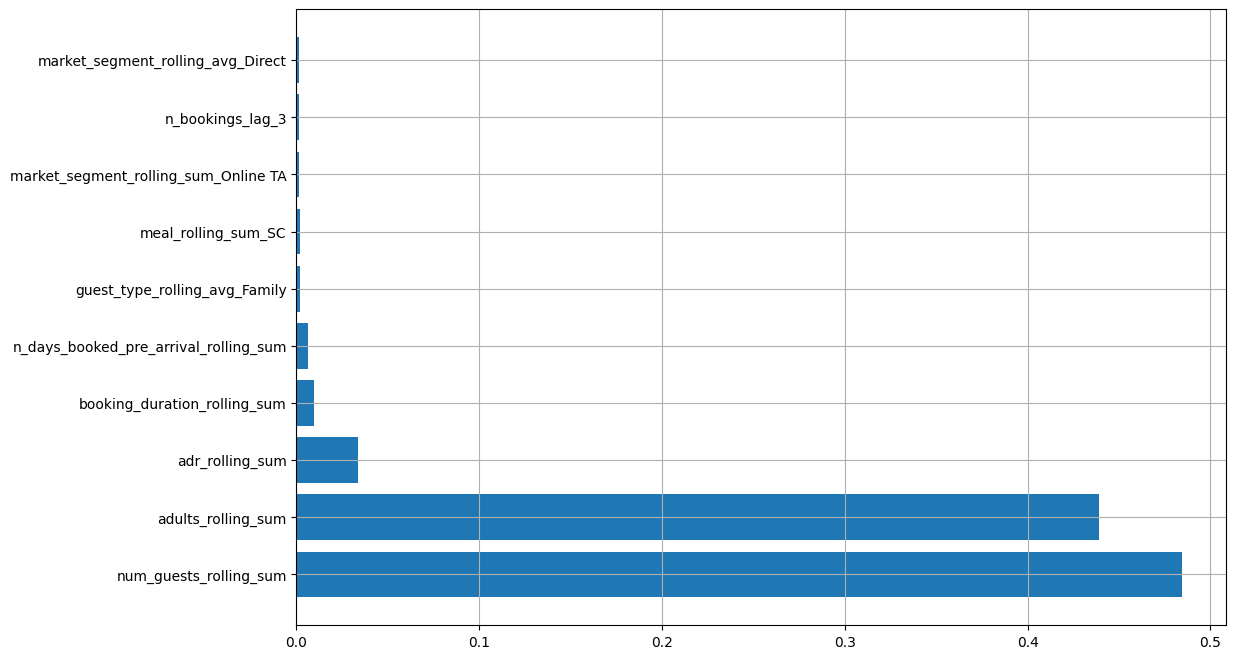

In [126]:
# plot the learnt importances for the last fold
df_imp = pd.DataFrame(
    {
        "feature": input_cols, 
        "importance": mdl.feature_importances_
    }
).sort_values('importance', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(df_imp['feature'].head(10), width=df_imp['importance'].head(10))
plt.grid(True)

The above learnt importances are generally in line with what we observed in the exploration phase.

# Evaluation

Here we compare the two models

In [63]:
df_eval = df_eval.merge(df_preds_rf, on=[time_ind_col, 'fold', 'hotel_name'], how='left')

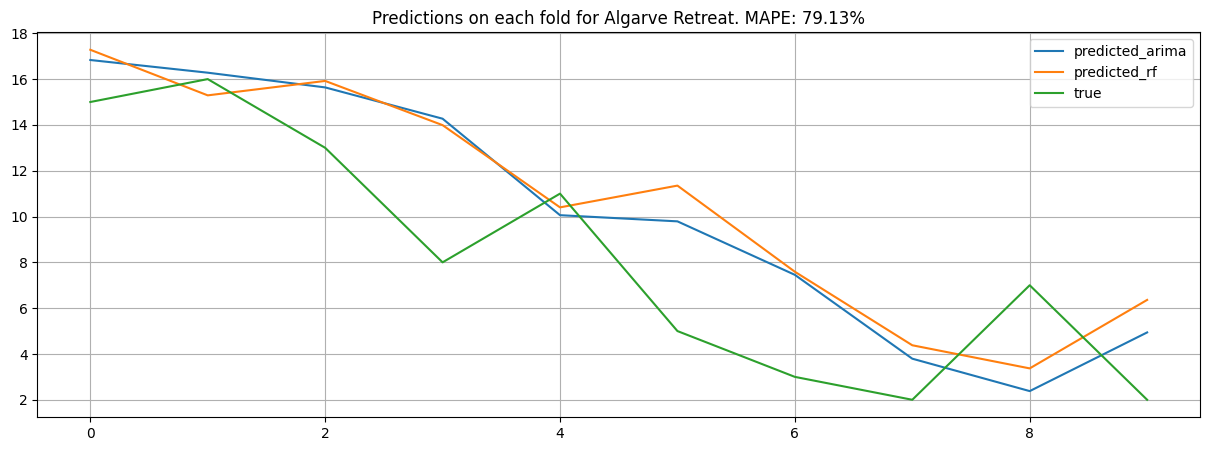

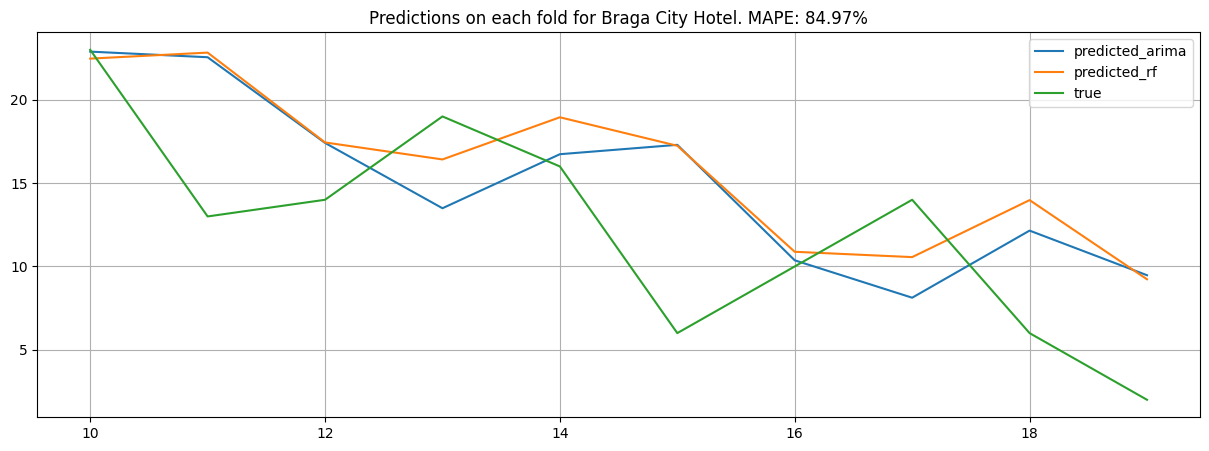

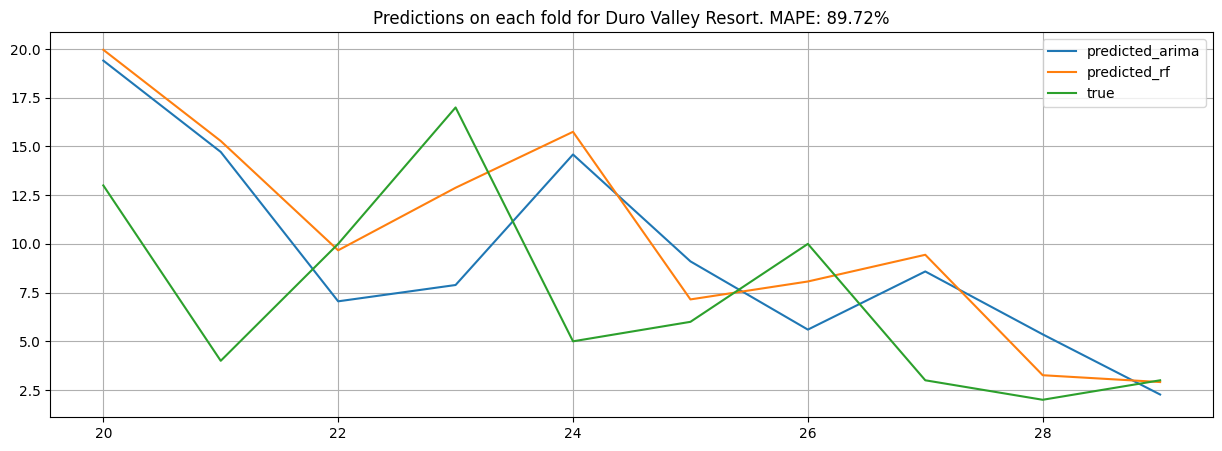

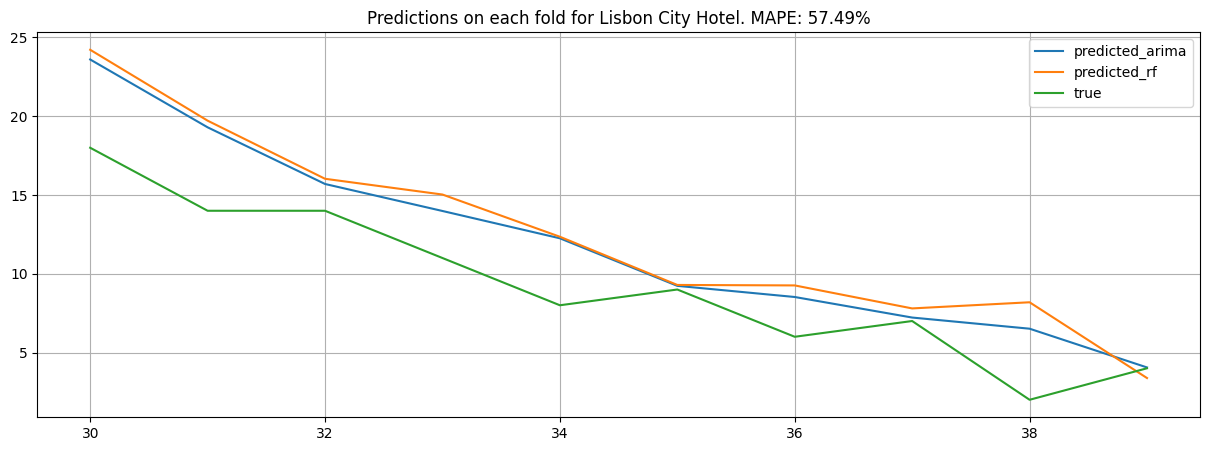

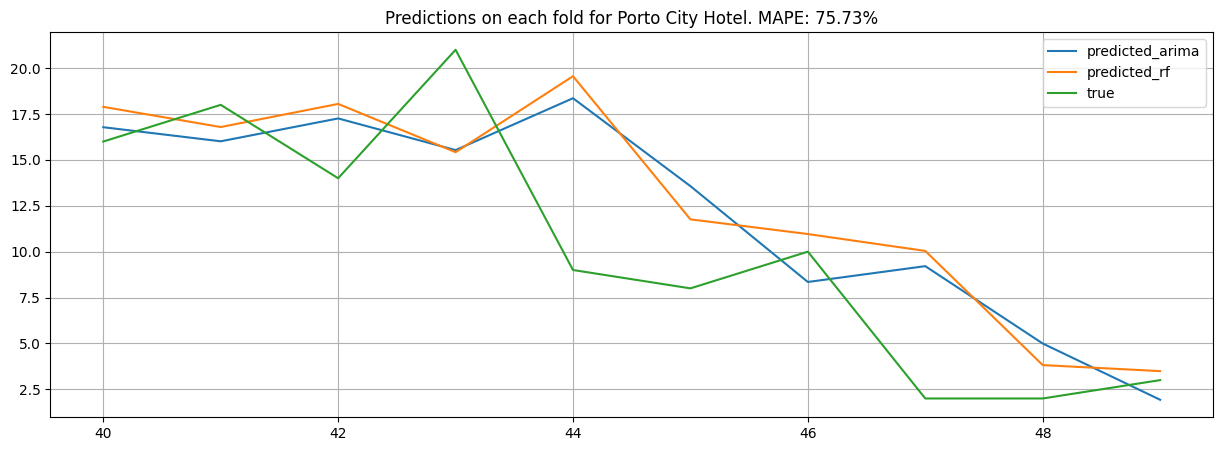

In [64]:
for hotel, gdf in df_eval.groupby('hotel_name'):
    fig = plt.figure(figsize=[15,5])
    plt.plot(gdf[f"pred_n_bookings"], label='predicted_arima')
    plt.plot(gdf[f"{target_col}_pred"], label='predicted_rf')
    plt.plot(gdf[target_col], label='true')
    plt.title(f"Predictions on each fold for {hotel}. MAPE: {round(sklearn.metrics.mean_absolute_percentage_error(gdf[target_col], gdf[target_col + '_pred'])*100, 2)}%")
    plt.grid(True)
    plt.legend()

In [65]:
df_eval['arima_ape'] = abs(df_eval['n_bookings'] - df_eval['pred_n_bookings']) / df_eval['n_bookings']
df_eval['rf_ape'] = abs(df_eval['n_bookings'] - df_eval['n_bookings_pred']) / df_eval['n_bookings']

In [66]:
df_eval['arima_ae'] = abs(df_eval['n_bookings'] - df_eval['pred_n_bookings'])
df_eval['rf_ae'] = abs(df_eval['n_bookings'] - df_eval['n_bookings_pred'])

## Histogram of APEs

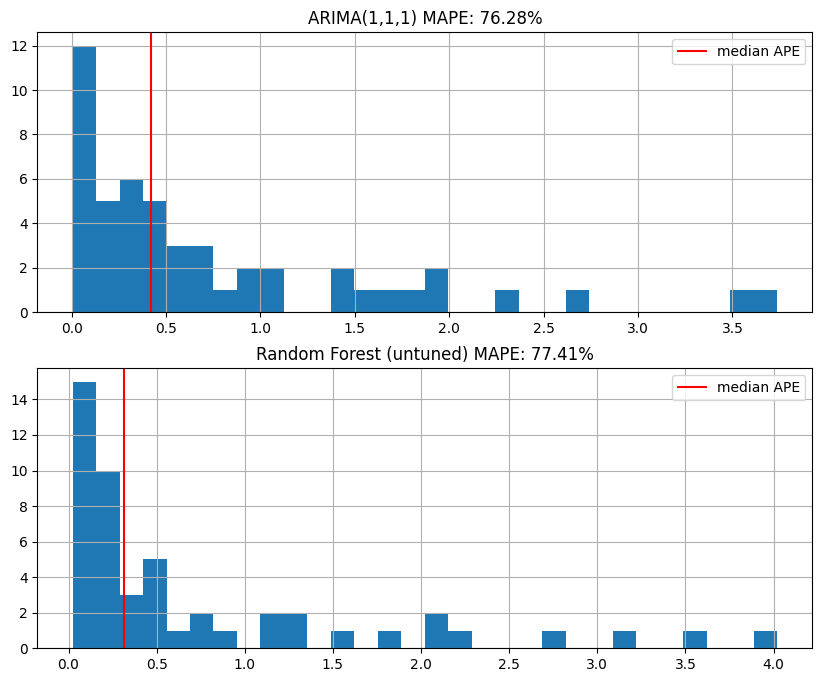

In [67]:
fig, (ax1, ax2) = plt.subplots(2,1)

fig.set_size_inches([10,8])

mape_arima = df_eval['arima_ape'].mean()
ax1.set_title(f"ARIMA(1,1,1) MAPE: {round(mape_arima*100, 2)}%")
ax1.hist(df_eval['arima_ape'], bins=30)
ax1.grid(True)
ax1.axvline(df_eval['arima_ape'].median(), color='red', label='median APE')
ax1.legend()

mape_rf = df_eval['rf_ape'].mean()
ax2.set_title(f"Random Forest (untuned) MAPE: {round(mape_rf*100, 2)}%")
ax2.hist(df_eval['rf_ape'], bins=30)
ax2.grid(True)
ax2.axvline(df_eval['rf_ape'].median(), color='red', label='median APE')
ax2.legend()

## Histogram of AEs

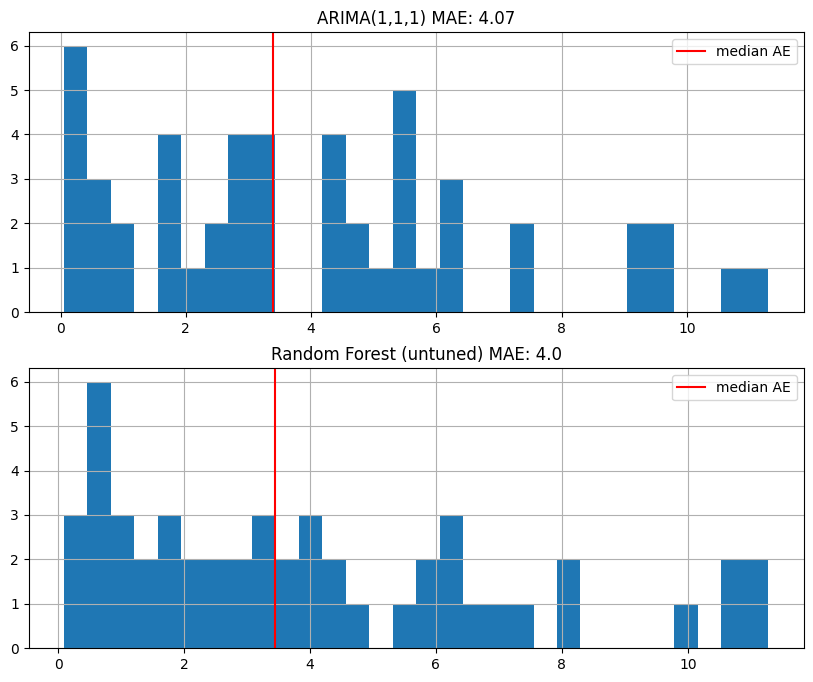

In [68]:
fig, (ax1, ax2) = plt.subplots(2,1)

fig.set_size_inches([10,8])

mae_arima = df_eval['arima_ae'].mean()
ax1.set_title(f"ARIMA(1,1,1) MAE: {round(mae_arima, 2)}")
ax1.hist(df_eval['arima_ae'], bins=30)
ax1.grid(True)
ax1.axvline(df_eval['arima_ae'].median(), color='red', label='median AE')
ax1.legend()


mae_rf = df_eval['rf_ae'].mean()
ax2.set_title(f"Random Forest (untuned) MAE: {round(mae_rf, 2)}")
ax2.hist(df_eval['rf_ae'], bins=30)
ax2.grid(True)
ax2.axvline(df_eval['rf_ae'].median(), color='red', label='median AE')
ax2.legend()

From here we could make the following observations:
1. The RF model is only marginally better than the ARIMA model.
2. Too many features may not always help although models like Random Forest are generally robust against the "curse of dimensionality".
3. Tuning the hyperparameters of the RF model, supplying more exogenous time series to the ARIMA could have improved.
4. Maybe if we have conducted the above CV experiment only near the peak seasons of 2016 and 2017 we could have witnessed a different behaviour.

Above I have chosen the classical metrics such as Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE). Since its a standard regression task and we notice that the ground truth `n_bookings` for all hotels are well conditioned (i.e. mostly above zero) there is no apparent harm. We could have chosen the sMAPE (which we use in the exploratory notebook) but still both MAPE and sMAPE tend to penalize the smaller predictions more heavily. Other variants of scaled errors could be [MASE](https://otexts.com/fpp3/accuracy.html#scaled-errors)

As further steps, we could have changed the way we are making predictions e.g. we could have use the same RF model to make predictions for the next 7 days and then add all the predictions to get a prediction for the whole next week.